In [1]:
!pip install -q rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 48.7 MB/s eta 0:00:00


In [2]:
# Data manipulation
import numpy as np
import pandas as pd
import polars as pl

# Geospatial
import geopandas as gpd
import rasterio
from rasterio.transform import from_bounds, Affine
from pyproj import Transformer

# Spatial analysis
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

# Preprocessing
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter
import folium
from folium.plugins import HeatMap

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Medellín boundaries (EPSG:4326)
LAT_MIN, LAT_MAX = 6.14722, 6.38402
LON_MIN, LON_MAX = -75.74590, -75.44199

# Coordinate Reference Systems
CRS_GEOGRAPHIC = "EPSG:4326"  # Lat/lon for web mapping
CRS_PROJECTED = "EPSG:3857"   # Web Mercator for distance calculations
CRS_UTM = "EPSG:32618"        # UTM Zone 18N for raster export

# Analysis parameters
INTERPOLATION_RES = 1000
AUTOMATON_ITERATIONS = 3
RISK_THRESHOLD = 0.65
INFLUENCE_RADIUS_M = 150

# File paths
PATH_POPULATION = '/content/col_pd_2020_1km_ASCII_XYZ.csv'
PATH_LANDSLIDES = '/content/Inventario_de_movimientos_en_masa_6829763638631547229.csv'
PATH_DEM = '/content/ASTGTMV003_N06W076_dem.tif'
PATH_PRECIPITATION = '/content/Colombia+Antioquia_Monthly.csv'

print("Configuration loaded")
print(f"Study area: {LAT_MIN}°-{LAT_MAX}°N, {LON_MIN}°-{LON_MAX}°E")

Configuration loaded
Study area: 6.14722°-6.38402°N, -75.7459°--75.44199°E


In [4]:
df_pop = pl.read_csv(PATH_POPULATION)

# Filter to Medellín boundaries
df_pop_med = df_pop.filter(
    (df_pop["Y"] >= LAT_MIN) & (df_pop["Y"] <= LAT_MAX) &
    (df_pop["X"] >= LON_MIN) & (df_pop["X"] <= LON_MAX)
)

# Convert to GeoDataFrame (EPSG:4326)
gdf_population = gpd.GeoDataFrame(
    df_pop_med.to_pandas(),
    geometry=gpd.points_from_xy(df_pop_med["X"], df_pop_med["Y"]),
    crs=CRS_GEOGRAPHIC
)

print(f"Population data loaded: {len(gdf_population):,} points")
gdf_population.head()

Population data loaded: 1,008 points


,X,Y,Z,geometry
0,-75.738750,6.37875,65.579300,POINT (-75.73875 6.37875)
1,-75.730416,6.37875,132.802643,POINT (-75.73042 6.37875)
2,-75.722083,6.37875,246.732437,POINT (-75.72208 6.37875)
3,-75.713750,6.37875,152.948898,POINT (-75.71375 6.37875)
4,-75.705416,6.37875,101.061119,POINT (-75.70542 6.37875)


In [6]:
df_landslides = pl.read_csv(PATH_LANDSLIDES)

# Create GeoDataFrame (original CRS: EPSG:3857)
gdf_landslides = gpd.GeoDataFrame(
    df_landslides.to_pandas(),
    geometry=gpd.points_from_xy(df_landslides["x"], df_landslides["y"]),
    crs=CRS_PROJECTED
)

# Convert to EPSG:4326 and filter to Medellín
gdf_landslides = gdf_landslides.to_crs(CRS_GEOGRAPHIC)
gdf_landslides = gdf_landslides[
    (gdf_landslides.geometry.y >= LAT_MIN) & (gdf_landslides.geometry.y <= LAT_MAX) &
    (gdf_landslides.geometry.x >= LON_MIN) & (gdf_landslides.geometry.x <= LON_MAX)
].reset_index(drop=True)

print(f"Historical landslides: {len(gdf_landslides)} events")
gdf_landslides.head()

Historical landslides: 25 events


,FID,OBJECTID,ID,Inentario_Movimiento,F35DOV_TIP,Tipo_Movimiento,Subtipo_Movimiento,Subtipo_nombre,Etiqueta,Representación_mapa,ESRI_OID,x,y,geometry
0,935,-7.583971e+56,6731,17472,69,Deslizamiento,3,Deslizamiento rotacional,Deslizamiento rotacional,dr,3005,-8.414176e+06,703476.898507,POINT (-75.58583 6.30667)
1,1368,-7.583971e+56,5628,50,71,Flujo,6,Flujo de lodo,Flujo,fl,1794,-8.414122e+06,688812.383074,POINT (-75.58534 6.17571)
2,2365,-7.583971e+56,424,28737,69,Deslizamiento,3,Deslizamiento rotacional,Deslizamiento rotacional,dr,556,-8.409755e+06,691656.160218,POINT (-75.54611 6.20111)
3,2373,-7.583971e+56,596,28577,69,Deslizamiento,3,Deslizamiento rotacional,Deslizamiento rotacional,dr,688,-8.400818e+06,689945.460842,POINT (-75.46583 6.18583)
4,2408,-7.583971e+56,442,28734,71,Flujo,5,Flujo de detritos,Flujo,fd,569,-8.409507e+06,705312.438505,POINT (-75.54389 6.32306)


In [9]:
with rasterio.open(PATH_DEM) as src:
    bounds = (LON_MIN, LAT_MIN, LON_MAX, LAT_MAX)
    window = rasterio.windows.from_bounds(*bounds, transform=src.transform)
    elevation_data = src.read(1, window=window)
    transform = src.window_transform(window)

# Convert raster to point GeoDataFrame
rows, cols = np.meshgrid(
    np.arange(elevation_data.shape[0]),
    np.arange(elevation_data.shape[1]),
    indexing="ij"
)

xs, ys = rasterio.transform.xy(transform, rows, cols)

gdf_elevation = gpd.GeoDataFrame(
    {
        "X": np.array(xs).flatten(),
        "Y": np.array(ys).flatten(),
        "elevation": elevation_data.flatten()
    },
    geometry=gpd.points_from_xy(np.array(xs).flatten(), np.array(ys).flatten()),
    crs=CRS_GEOGRAPHIC
).dropna(subset=['elevation'])

print(f"Elevation data: {len(gdf_elevation):,} points")
print(f"Elevation range: {gdf_elevation['elevation'].min():.0f} - {gdf_elevation['elevation'].max():.0f} m")

Elevation data: 932,088 points
Elevation range: 948 - 3148 m


In [10]:
# Convert to projected CRS for accurate distance calculations
gdf_elevation_proj = gdf_elevation.to_crs(CRS_PROJECTED)

X_m = gdf_elevation_proj.geometry.x.values
Y_m = gdf_elevation_proj.geometry.y.values
Z = gdf_elevation_proj["elevation"].values

# Remove NaN values
mask = ~np.isnan(X_m) & ~np.isnan(Y_m) & ~np.isnan(Z)
X_m, Y_m, Z = X_m[mask], Y_m[mask], Z[mask]

# Create interpolation grid
xi = np.linspace(X_m.min(), X_m.max(), INTERPOLATION_RES)
yi = np.linspace(Y_m.min(), Y_m.max(), INTERPOLATION_RES)
xx, yy = np.meshgrid(xi, yi)

# Interpolate elevation
print("Interpolating elevation...")
zz = griddata(np.column_stack((X_m, Y_m)), Z, (xx, yy), method='cubic')

# Calculate slope
dx = np.gradient(xx, axis=1)
dy = np.gradient(yy, axis=0)
dzdx = np.gradient(zz, axis=1) / dx
dzdy = np.gradient(zz, axis=0) / dy

slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
slope_deg = np.degrees(slope_rad)

# Convert to GeoDataFrame
gdf_slope = gpd.GeoDataFrame(
    {
        "X": xx.flatten(),
        "Y": yy.flatten(),
        "slope": slope_deg.flatten()
    },
    geometry=gpd.points_from_xy(xx.flatten(), yy.flatten()),
    crs=CRS_PROJECTED
).to_crs(CRS_GEOGRAPHIC)

print(f"Slope calculated: {len(gdf_slope):,} points")
print(f"Slope range: {gdf_slope['slope'].min():.1f}° - {gdf_slope['slope'].max():.1f}°")


Interpolating elevation...
Slope calculated: 1,000,000 points
Slope range: 0.0° - 77.3°


In [11]:
df_precipitation = pd.read_csv(PATH_PRECIPITATION)
print("Precipitation data loaded")
df_precipitation.head()

Precipitation data loaded


,Month,Period,2020,Unnamed: 3
0,Jan,1,71.1040,NaN
1,Feb,2,54.7099,NaN
2,Mar,3,51.7355,NaN
3,Apr,4,219.0628,NaN
4,May,5,282.0451,NaN


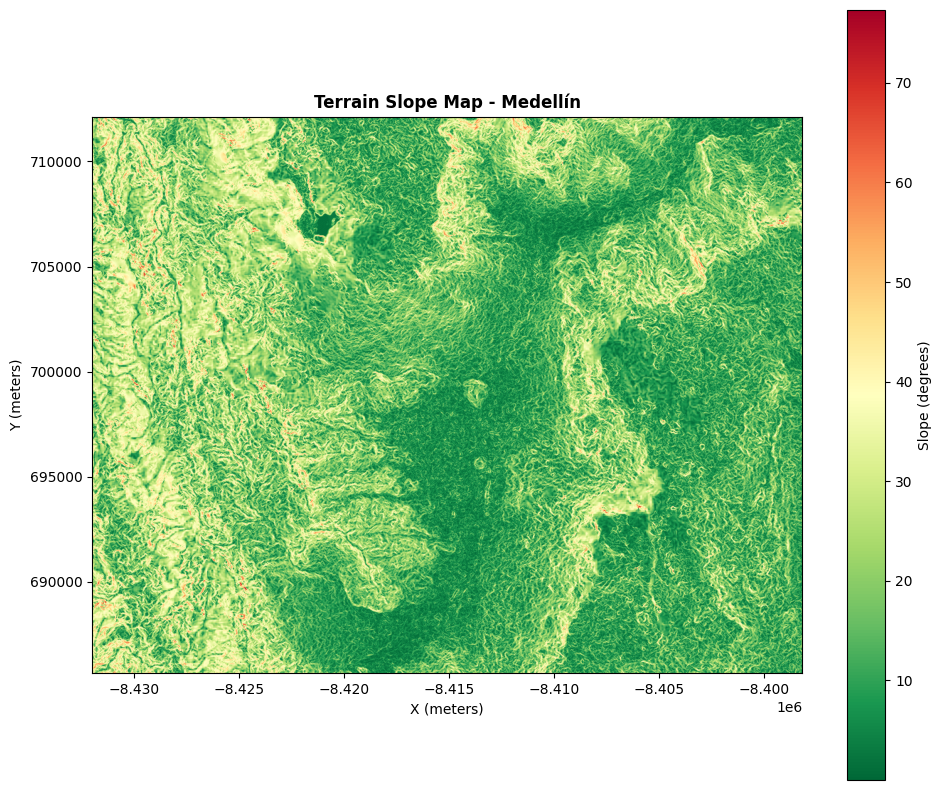

In [12]:
plt.figure(figsize=(10, 8))
plt.imshow(
    slope_deg,
    origin='lower',
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap='RdYlGn_r'
)
plt.colorbar(label="Slope (degrees)")
plt.title("Terrain Slope Map - Medellín", fontweight='bold')
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.tight_layout()
plt.savefig("slope_map.png", dpi=300, bbox_inches='tight')
plt.show()

In [13]:

map_center = [(LAT_MIN + LAT_MAX) / 2, (LON_MIN + LON_MAX) / 2]
m = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB positron")

heat_data = [
    [row.geometry.y, row.geometry.x, row["Z"]]
    for _, row in gdf_population.dropna(subset=["Z"]).iterrows()
]

HeatMap(
    heat_data,
    radius=15,
    blur=25,
    max_zoom=12,
    gradient={0.2: "green", 0.5: "yellow", 0.8: "red"}
).add_to(m)

m.save("population_heatmap.html")
print("Interactive population heatmap saved: population_heatmap.html")
m


Interactive population heatmap saved: population_heatmap.html


In [15]:
print("Calculating slope risk...")

# Build spatial tree for slope data
slope_coords = np.column_stack([gdf_slope.geometry.x, gdf_slope.geometry.y])
pop_coords = np.column_stack([gdf_population.geometry.x, gdf_population.geometry.y])
tree_slope = cKDTree(slope_coords)

# Find nearest neighbors and interpolate
distances, indices = tree_slope.query(pop_coords, k=10)
slope_values = gdf_slope.iloc[indices.flatten()]['slope'].values.reshape(indices.shape)

# Weighted average by inverse distance
weights = 1.0 / (distances + 1e-10)
weights = weights / weights.sum(axis=1, keepdims=True)

gdf_population['slope_mean'] = np.sum(slope_values * weights, axis=1)
gdf_population['slope_std'] = np.std(slope_values, axis=1)

# Classify slope risk
def slope_risk_function(slope):
    if slope < 15: return 0.05
    elif slope < 25: return 0.15
    elif slope < 35: return 0.35
    elif slope < 45: return 0.65
    else: return 0.90

gdf_population['slope_risk'] = gdf_population['slope_mean'].apply(slope_risk_function)

print(f"Slope risk calculated - Mean: {gdf_population['slope_risk'].mean():.3f}")

Calculating slope risk...
Slope risk calculated - Mean: 0.169


In [16]:
print("Calculating historical landslide risk...")

if len(gdf_landslides) > 0:
    landslide_coords = np.column_stack([gdf_landslides.geometry.x, gdf_landslides.geometry.y])
    tree_landslides = cKDTree(landslide_coords)

    distances, _ = tree_landslides.query(pop_coords, k=1)

    # Exponential decay (500m influence radius)
    max_distance = 0.005  # ~500m in degrees
    gdf_population['dist_to_landslide'] = distances
    gdf_population['historical_risk'] = np.exp(-distances / (max_distance * 0.5))
    gdf_population['historical_risk'] = np.clip(gdf_population['historical_risk'], 0, 0.8)
else:
    gdf_population['historical_risk'] = 0.0

print(f"Historical risk calculated - Mean: {gdf_population['historical_risk'].mean():.3f}")

# ============================================================================
# CELL 14: RISK ANALYSIS - Calculate Precipitation Risk
# ============================================================================

print("Calculating precipitation risk...")

if '2020' in df_precipitation.columns:
    annual_precip = df_precipitation['2020'].sum()

    if annual_precip < 1500: precip_risk = 0.10
    elif annual_precip < 2500: precip_risk = 0.25
    elif annual_precip < 3500: precip_risk = 0.40
    else: precip_risk = 0.60

    gdf_population['precip_risk'] = precip_risk
else:
    gdf_population['precip_risk'] = 0.25

print(f"Precipitation risk: {gdf_population['precip_risk'].iloc[0]:.3f}")

Calculating historical landslide risk...
Historical risk calculated - Mean: 0.011
Calculating precipitation risk...
Precipitation risk: 0.400


In [17]:
print("Combining risk factors...")

# Weighted combination
weights = {
    'slope_risk': 0.50,
    'historical_risk': 0.25,
    'precip_risk': 0.15,
    'elevation_norm': 0.10
}

gdf_population['risk_combined'] = (
    gdf_population['slope_risk'] * weights['slope_risk'] +
    gdf_population['historical_risk'] * weights['historical_risk'] +
    gdf_population['precip_risk'] * weights['precip_risk'] +
    gdf_population['elevation_norm'] * weights['elevation_norm']
)

gdf_population['risk_combined'] = np.clip(gdf_population['risk_combined'], 0, 1)

print(f"Combined risk - Mean: {gdf_population['risk_combined'].mean():.3f}")
print(f"Combined risk - Max: {gdf_population['risk_combined'].max():.3f}")

# ============================================================================
# CELL 16: CELLULAR AUTOMATON - Spatial Risk Propagation
# ============================================================================

print(f"Running cellular automaton ({AUTOMATON_ITERATIONS} iterations)...")

gdf_population['risk_current'] = gdf_population['risk_combined'].copy()

coords = np.column_stack([gdf_population.geometry.x, gdf_population.geometry.y])
tree_ca = cKDTree(coords)

radius = 0.0015  # ~150m in degrees

for iteration in range(AUTOMATON_ITERATIONS):
    new_risk = gdf_population['risk_current'].copy()

    for idx in range(len(gdf_population)):
        neighbors_idx = tree_ca.query_ball_point(coords[idx], r=radius)

        if len(neighbors_idx) > 1:
            neighbor_risks = gdf_population.iloc[neighbors_idx]['risk_current'].values
            neighbor_influence = np.mean(neighbor_risks) * 0.10
            current_risk = gdf_population.iloc[idx]['risk_current']
            new_risk.iloc[idx] = min(current_risk + neighbor_influence, 1.0)

    gdf_population['risk_current'] = new_risk
    print(f"  Iteration {iteration + 1} complete")

print("Cellular automaton complete")

Combining risk factors...
Combined risk - Mean: 0.169
Combined risk - Max: 0.510
Running cellular automaton (3 iterations)...
  Iteration 1 complete
  Iteration 2 complete
  Iteration 3 complete
Cellular automaton complete


In [18]:
def classify_risk(risk):
    if risk < 0.25: return 'Low'
    elif risk < 0.45: return 'Moderate'
    elif risk < 0.65: return 'High'
    else: return 'Very High'

gdf_population['risk_level'] = gdf_population['risk_current'].apply(classify_risk)

# Statistics
risk_stats = gdf_population['risk_level'].value_counts()
print("\nRisk Distribution:")
for level in ['Low', 'Moderate', 'High', 'Very High']:
    if level in risk_stats.index:
        count = risk_stats[level]
        pct = (count / len(gdf_population)) * 100
        print(f"  {level}: {count:,} points ({pct:.1f}%)")


Risk Distribution:
  Low: 915 points (90.8%)
  Moderate: 91 points (9.0%)
  High: 2 points (0.2%)


In [19]:
high_risk_zones = gdf_population[gdf_population['risk_current'] >= RISK_THRESHOLD]

alerts = []
for idx, row in high_risk_zones.iterrows():
    alert = {
        'id': idx,
        'lat': row.geometry.y,
        'lon': row.geometry.x,
        'risk_score': row['risk_current'],
        'risk_level': row['risk_level'],
        'slope': row['slope_mean'],
        'priority': 'URGENT' if row['risk_current'] > 0.80 else 'HIGH'
    }
    alerts.append(alert)

df_alerts = pd.DataFrame(alerts)
df_alerts.to_csv("landslide_alerts.csv", index=False)

print(f"\n{len(alerts)} alerts generated")
print(f"Alerts saved: landslide_alerts.csv")



0 alerts generated
Alerts saved: landslide_alerts.csv


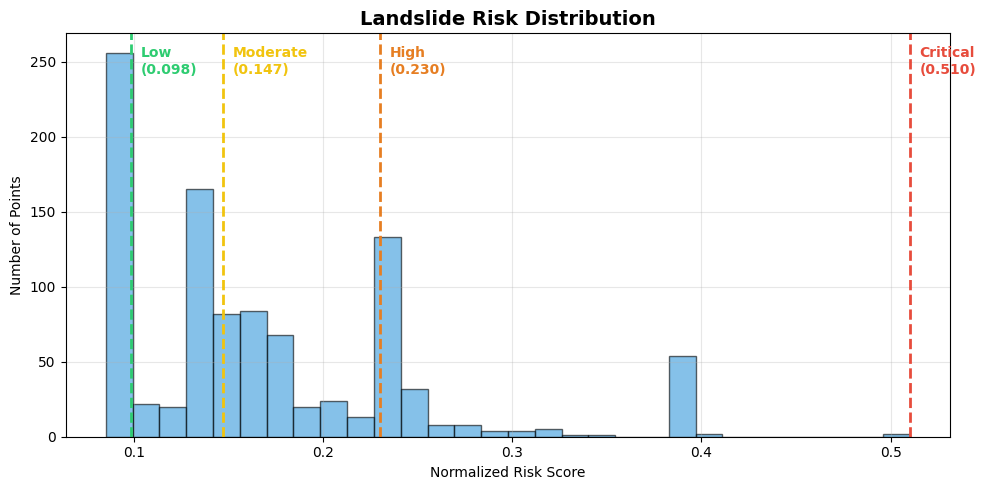

In [20]:
risk_values = gdf_population['risk_current']

q25 = risk_values.quantile(0.25)
q50 = risk_values.quantile(0.50)
q75 = risk_values.quantile(0.75)

thresholds = {'Low': q25, 'Moderate': q50, 'High': q75, 'Critical': risk_values.max()}
colors = {'Low': '#2ecc71', 'Moderate': '#f1c40f', 'High': '#e67e22', 'Critical': '#e74c3c'}

plt.figure(figsize=(10, 5), facecolor='white')
plt.hist(risk_values, bins=30, color='#3498db', alpha=0.6, edgecolor='black')

for label, value in thresholds.items():
    plt.axvline(value, color=colors[label], linestyle='--', linewidth=2)
    plt.text(value + 0.005, plt.ylim()[1] * 0.9, f'{label}\n({value:.3f})',
             color=colors[label], fontweight='bold')

plt.title('Landslide Risk Distribution', fontsize=14, weight='bold')
plt.xlabel('Normalized Risk Score')
plt.ylabel('Number of Points')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("risk_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


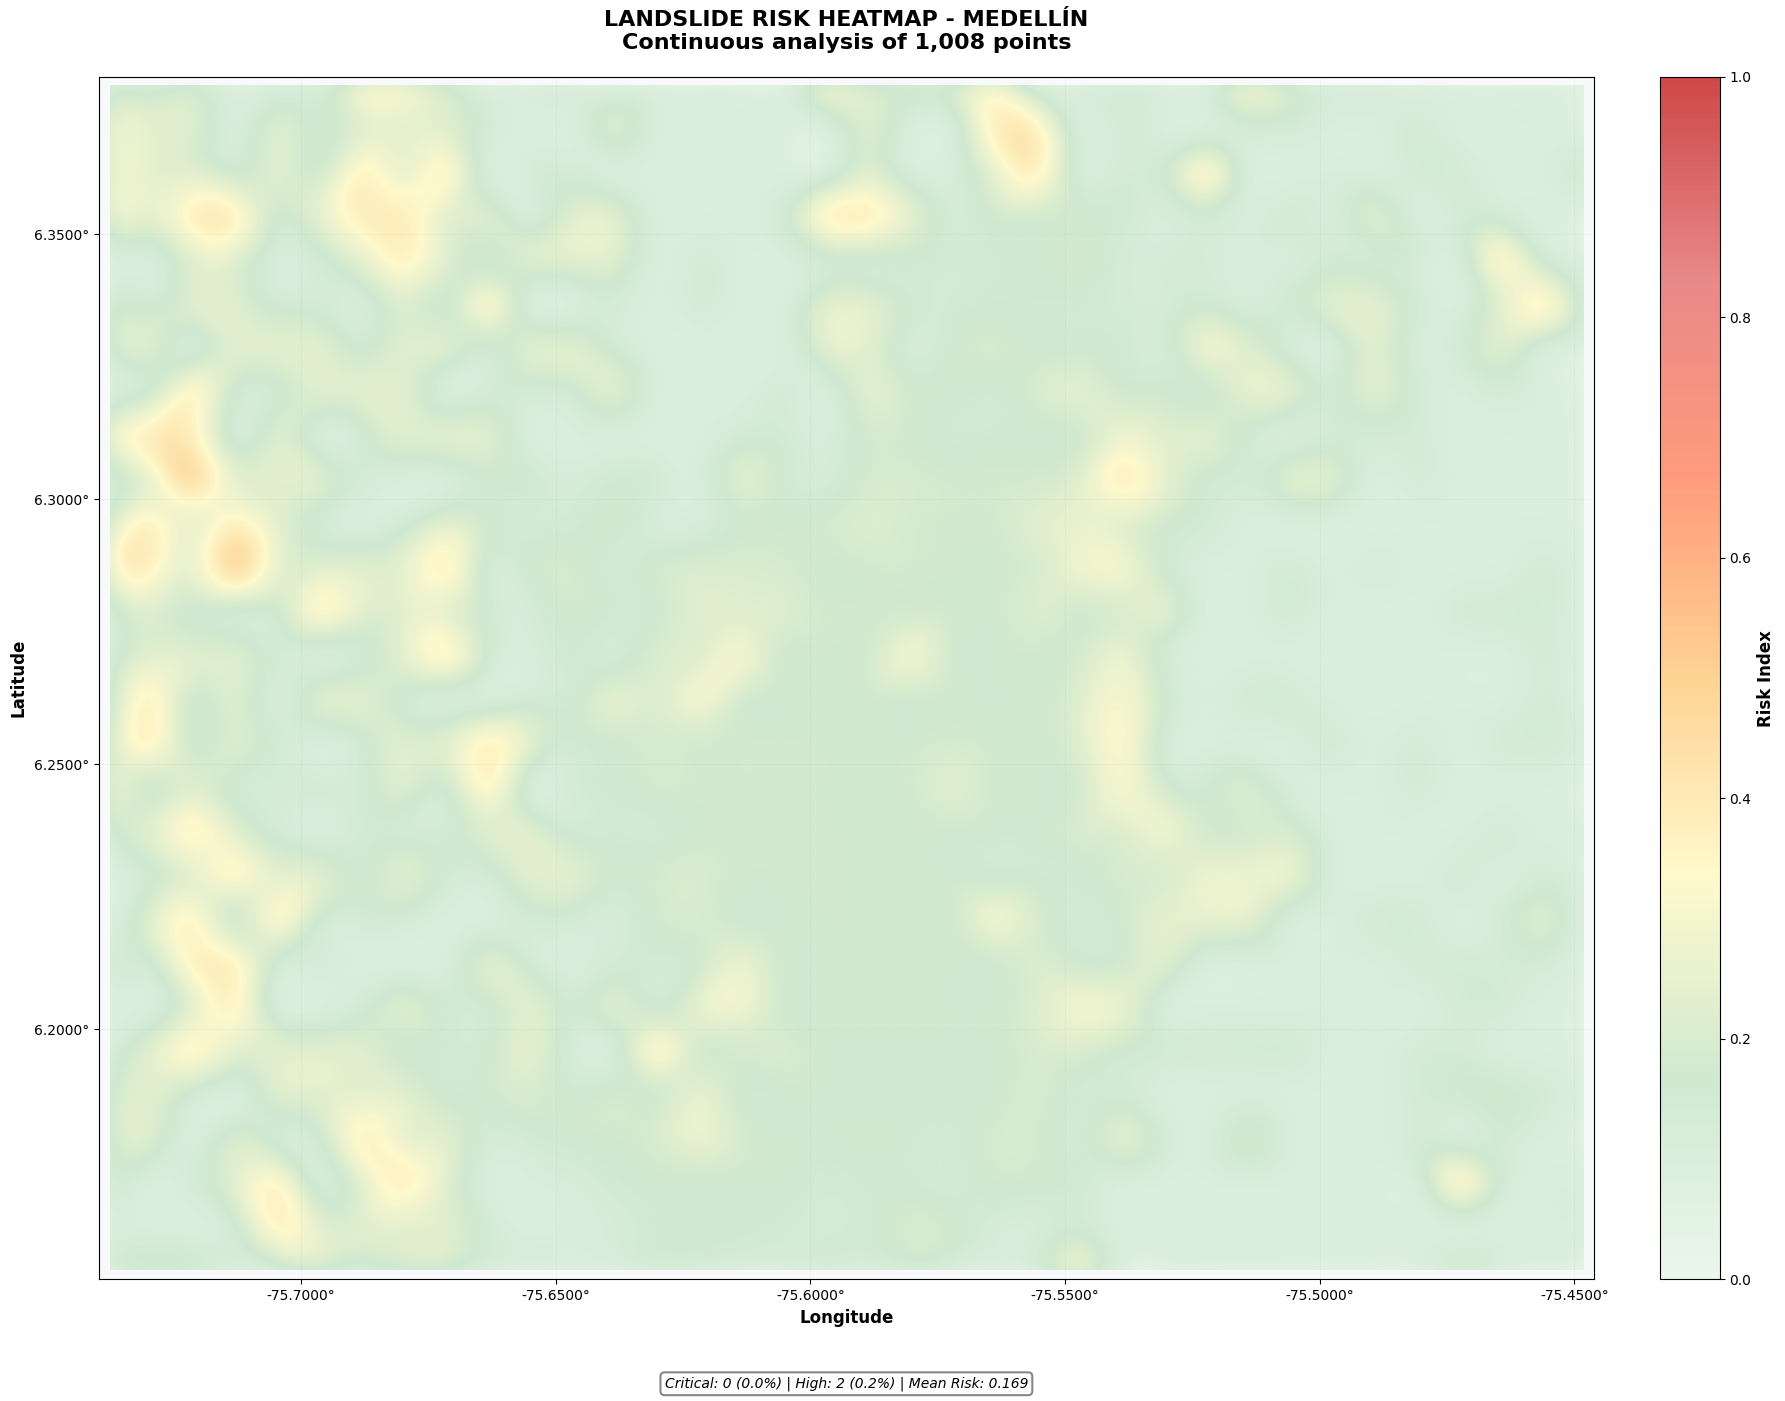

In [21]:
def create_risk_heatmap(gdf, alerts_df=None, resolution=200):
    """Generate continuous risk heatmap"""

    points = np.column_stack([gdf.geometry.x, gdf.geometry.y])
    values = gdf['risk_current'].values

    lon_min = points[:, 0].min() - 0.001
    lon_max = points[:, 0].max() + 0.001
    lat_min = points[:, 1].min() - 0.001
    lat_max = points[:, 1].max() + 0.001

    grid_lon = np.linspace(lon_min, lon_max, resolution)
    grid_lat = np.linspace(lat_min, lat_max, resolution)
    grid_lon_mesh, grid_lat_mesh = np.meshgrid(grid_lon, grid_lat)

    # Interpolate
    grid_risk = griddata(points, values, (grid_lon_mesh, grid_lat_mesh),
                        method='cubic', fill_value=np.nan)

    # Smooth
    mask = ~np.isnan(grid_risk)
    grid_risk_smooth = gaussian_filter(np.nan_to_num(grid_risk), sigma=2.0)
    grid_risk_smooth[~mask] = np.nan

    # Plot
    fig, ax = plt.subplots(figsize=(18, 14), facecolor='white')
    ax.set_facecolor('#f8f9fa')

    colors = ['#e8f5e9', '#c8e6c9', '#fff9c4', '#ffcc80', '#ff8a65', '#e57373', '#c62828']
    cmap = mcolors.LinearSegmentedColormap.from_list('risk_smooth', colors, N=256)

    im = ax.imshow(grid_risk_smooth, extent=[lon_min, lon_max, lat_min, lat_max],
                  origin='lower', cmap=cmap, alpha=0.85, aspect='auto',
                  interpolation='bilinear', vmin=0, vmax=1)

    # Critical zones contours
    high_risk_mask = grid_risk_smooth > RISK_THRESHOLD
    if high_risk_mask.any():
        contours = ax.contour(grid_lon_mesh, grid_lat_mesh, grid_risk_smooth,
                             levels=[0.65, 0.8], colors=['#d32f2f', '#b71c1c'],
                             linewidths=[2, 3], alpha=0.8)
        ax.clabel(contours, inline=True, fontsize=10, fmt='%.2f',
                 colors='darkred', fontweight='bold')

    # Alert markers
    if alerts_df is not None and len(alerts_df) > 0:
        ax.scatter(alerts_df['lon'], alerts_df['lat'],
                  color='#b71c1c', s=300, marker='*',
                  edgecolors='yellow', linewidths=2.5,
                  label=f'Critical Zones ({len(alerts_df)})', zorder=10)

    ax.set_xlabel('Longitude', fontsize=12, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=12, fontweight='bold')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f°'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f°'))
    ax.tick_params(labelsize=10)
    ax.grid(True, alpha=0.2, linestyle=':', linewidth=0.5, color='gray')

    ax.set_title('LANDSLIDE RISK HEATMAP - MEDELLÍN\n' +
                f'Continuous analysis of {len(gdf):,} points',
                fontsize=16, fontweight='bold', pad=20)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Risk Index', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)

    if alerts_df is not None and len(alerts_df) > 0:
        ax.legend(loc='upper right', fontsize=11, framealpha=0.95,
                 edgecolor='black', shadow=True)

    high_risk_count = (values >= RISK_THRESHOLD).sum()
    moderate_count = ((values >= 0.45) & (values < RISK_THRESHOLD)).sum()
    stats = (f"Critical: {high_risk_count} ({100*high_risk_count/len(values):.1f}%) | "
            f"High: {moderate_count} ({100*moderate_count/len(values):.1f}%) | "
            f"Mean Risk: {values.mean():.3f}")
    ax.text(0.5, -0.09, stats, transform=ax.transAxes,
           ha='center', fontsize=10, style='italic',
           bbox=dict(boxstyle='round', facecolor='white',
                    alpha=0.95, edgecolor='gray', linewidth=1.5))

    plt.tight_layout()
    return fig, ax

fig, ax = create_risk_heatmap(gdf_population, df_alerts, resolution=200)
plt.savefig("risk_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()


In [22]:
def export_risk_geotiff(gdf, output_path='medellin_risk.tif',
                       resolution=30, smooth_sigma=1.5):
    """Export risk map as GeoTIFF in EPSG:32618 (UTM Zone 18N)"""

    print(f"Exporting risk map to GeoTIFF...")
    print(f"  Original CRS: {gdf.crs}")

    # Reproject to UTM
    if gdf.crs != CRS_UTM:
        print(f"  Reprojecting to {CRS_UTM}...")
        gdf_utm = gdf.to_crs(CRS_UTM)
    else:
        gdf_utm = gdf.copy()

    # Extract coordinates and values
    points = np.column_stack([gdf_utm.geometry.x, gdf_utm.geometry.y])
    values = gdf_utm['risk_current'].values

    print(f"  Points: {len(points):,}")
    print(f"  X range: {points[:,0].min():.0f} - {points[:,0].max():.0f} m")
    print(f"  Y range: {points[:,1].min():.0f} - {points[:,1].max():.0f} m")

    # Define bounds with buffer
    x_min, x_max = points[:, 0].min() - 500, points[:, 0].max() + 500
    y_min, y_max = points[:, 1].min() - 500, points[:, 1].max() + 500

    # Calculate raster dimensions
    width = int((x_max - x_min) / resolution)
    height = int((y_max - y_min) / resolution)

    print(f"  Raster dimensions: {width} x {height} pixels")
    print(f"  Resolution: {resolution} m/pixel")

    # Create regular grid
    x_coords = np.linspace(x_min, x_max, width)
    y_coords = np.linspace(y_min, y_max, height)
    grid_x, grid_y = np.meshgrid(x_coords, y_coords)

    # Interpolate
    print(f"  Interpolating values...")
    grid_risk = griddata(points, values, (grid_x, grid_y),
                        method='cubic', fill_value=np.nan)

    # Smooth
    if smooth_sigma > 0:
        print(f"  Applying smoothing (sigma={smooth_sigma})...")
        mask = ~np.isnan(grid_risk)
        grid_risk_smooth = gaussian_filter(np.nan_to_num(grid_risk), sigma=smooth_sigma)
        grid_risk_smooth[~mask] = np.nan
    else:
        grid_risk_smooth = grid_risk

    # Flip Y axis (GeoTIFF convention)
    grid_risk_final = np.flipud(grid_risk_smooth)

    # Create geospatial transform
    pixel_width = (x_max - x_min) / width
    pixel_height = (y_max - y_min) / height
    transform = Affine.translation(x_min, y_max) * Affine.scale(pixel_width, -pixel_height)

    # Save as GeoTIFF
    print(f"  Saving {output_path}...")

    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=rasterio.float32,
        crs=CRS_UTM,
        transform=transform,
        nodata=np.nan,
        compress='lzw'
    ) as dst:
        dst.write(grid_risk_final.astype(rasterio.float32), 1)
        dst.set_band_description(1, 'Landslide Risk Index')
        dst.update_tags(
            TITLE='Landslide Risk Map - Medellín',
            DESCRIPTION='Landslide risk index (0-1)',
            RESOLUTION=f'{resolution}m',
            CRS=f'{CRS_UTM} (UTM Zone 18N)',
            MIN_RISK=f'{np.nanmin(grid_risk_final):.3f}',
            MAX_RISK=f'{np.nanmax(grid_risk_final):.3f}',
            MEAN_RISK=f'{np.nanmean(grid_risk_final):.3f}'
        )

    print(f"  GeoTIFF exported successfully!")
    print(f"\nRaster statistics:")
    print(f"  Min: {np.nanmin(grid_risk_final):.3f}")
    print(f"  Max: {np.nanmax(grid_risk_final):.3f}")
    print(f"  Mean: {np.nanmean(grid_risk_final):.3f}")
    print(f"  Valid pixels: {np.sum(~np.isnan(grid_risk_final)):,}")

    return output_path

# Export continuous risk map
tif_path = export_risk_geotiff(
    gdf_population,
    output_path='medellin_risk.tif',
    resolution=30,
    smooth_sigma=1.5
)

Exporting risk map to GeoTIFF...
  Original CRS: EPSG:4326
  Reprojecting to EPSG:32618...
  Points: 1,008
  X range: 418264 - 450556 m
  Y range: 680221 - 705131 m
  Raster dimensions: 1109 x 863 pixels
  Resolution: 30 m/pixel
  Interpolating values...
  Applying smoothing (sigma=1.5)...
  Saving medellin_risk.tif...
  GeoTIFF exported successfully!

Raster statistics:
  Min: -0.138
  Max: 0.662
  Mean: 0.169
  Valid pixels: 888,761


In [23]:
print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print("\nGenerated files:")
print("  1. medellin_risk.tif - Risk map (GeoTIFF, EPSG:32618)")
print("  2. landslide_alerts.csv - High-risk zone alerts")
print("  3. risk_heatmap.png - Continuous risk visualization")
print("  4. risk_distribution.png - Risk distribution histogram")
print("  5. slope_map.png - Terrain slope analysis")
print("  6. population_heatmap.html - Interactive population density")
print("\nStatistics:")
print(f"  Points analyzed: {len(gdf_population):,}")
print(f"  Mean risk: {gdf_population['risk_current'].mean():.3f}")
print(f"  Max risk: {gdf_population['risk_current'].max():.3f}")
print(f"  High-risk zones: {len(df_alerts)}")
print(f"  Critical zones (>0.8): {(gdf_population['risk_current'] > 0.80).sum()}")
print("\n" + "="*70)


ANALYSIS COMPLETE

Generated files:
  1. medellin_risk.tif - Risk map (GeoTIFF, EPSG:32618)
  2. landslide_alerts.csv - High-risk zone alerts
  3. risk_heatmap.png - Continuous risk visualization
  4. risk_distribution.png - Risk distribution histogram
  5. slope_map.png - Terrain slope analysis
  6. population_heatmap.html - Interactive population density

Statistics:
  Points analyzed: 1,008
  Mean risk: 0.169
  Max risk: 0.510
  High-risk zones: 0
  Critical zones (>0.8): 0

